# Rides

Here is where we do analysis on all the trip data of Citibikes.

In [180]:
import pandas as pd
import pickle
from collections import defaultdict

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

### Loading the stations data

In [210]:
class Stations:
    def __init__(self, path):
        self.stations = pickle.load(open(path, "rb"))
        
    def get_by_id(self, station_id):
        return self.stations[self.stations.id == station_id]
    
    def head(self, count=5):
        return self.stations.head(count)
    
    def get_areas(self):
        return self.stations[["area", "area_id"]].drop_duplicates()[:-1]

In [211]:
stations = Stations("../data/augmented_stations.pickle")

In [195]:
stations.head()

,id,latitude,longitude,stationName,city,neighborhood,neighborhood_id,area,area_id
0,72,40.767272,-73.993929,W 52 St & 11 Ave,New York,All Midtown,119,Midtown West,124
1,79,40.719116,-74.006667,Franklin St & W Broadway,New York,All Downtown,102,Tribeca,105
2,82,40.711174,-74.000165,St James Pl & Pearl St,New York,Chinatown,110,Two Bridges,111
3,83,40.683826,-73.976323,Atlantic Ave & Fort Greene Pl,Brooklyn,Brooklyn,300,Fort Greene,304
4,116,40.741776,-74.001497,W 17 St & 8 Ave,New York,All Downtown,102,Chelsea,115


In [174]:
stations.get_by_id(72)

,id,latitude,longitude,stationName,city,neighborhood,neighborhood_id,area,area_id
0,72,40.767272,-73.993929,W 52 St & 11 Ave,New York,All Midtown,119,Midtown West,124


In [176]:
stations.get_by_id(72).area.item()

u'Midtown West'


### Loading Sample Citibike Trip Data

In [29]:
trip_data = pd.read_csv("../data/trip-data/sample.csv")

In [38]:
trip_data.columns

Index([u'tripduration', u'starttime', u'stoptime', u'start station id', u'start station name', u'start station latitude', u'start station longitude', u'end station id', u'end station name', u'end station latitude', u'end station longitude', u'bikeid', u'usertype', u'birth year', u'gender'], dtype='object')

In [30]:
trip_data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1346,1/1/2015 0:01,1/1/2015 0:24,455,1 Ave & E 44 St,40.750020,-73.969053,265,Stanton St & Chrystie St,40.722293,-73.991475,18660,Subscriber,1960,2
1,363,1/1/2015 0:02,1/1/2015 0:08,434,9 Ave & W 18 St,40.743174,-74.003664,482,W 15 St & 7 Ave,40.739355,-73.999318,16085,Subscriber,1963,1
2,346,1/1/2015 0:04,1/1/2015 0:10,491,E 24 St & Park Ave S,40.740964,-73.986022,505,6 Ave & W 33 St,40.749013,-73.988484,20845,Subscriber,1974,1
3,182,1/1/2015 0:04,1/1/2015 0:07,384,Fulton St & Waverly Ave,40.683178,-73.965964,399,Lafayette Ave & St James Pl,40.688515,-73.964763,19610,Subscriber,1969,1
4,969,1/1/2015 0:05,1/1/2015 0:21,474,5 Ave & E 29 St,40.745168,-73.986831,432,E 7 St & Avenue A,40.726218,-73.983799,20197,Subscriber,1977,1


### Obtain the Popular Stations

This includes the number of times a station was either the source or destination in a trip taken.

In [66]:
# Number of times a station was the start station.
start_station_count = trip_data.groupby("start station id").size()

# Number of times a station was the end station.
end_station_count = trip_data.groupby("end station id").size()

**create an interface to access station count in data given the station id**

In [72]:
def get_station_count(data, station_id):
    return data[station_id] if station_id in data else 0

In [74]:
get_station_count(start_station_count, 3002)

57

**creating final station counts as a python dict**

In [101]:
station_counts = dict()

In [102]:
for station_id in stations.id:
    station_counts[station_id] = get_station_count(start_station_count, station_id) + \
                                 get_station_count(end_station_count, station_id)

In [177]:
popular_stations = sorted(station_counts, key= lambda e: station_counts[e], reverse=True)

In [179]:
for station_id in popular_stations[:10]:
    info = stations.get_by_id(station_id=station_id)
    area = info.area.item()
    print `station_id` + ", " + area + " : " + `station_counts[station_id]`

293, East Village : 206
285, East Village : 204
497, Flatiron : 188
504, Stuyvesant Town/PCV : 173
382, Greenwich Village : 171
521, Midtown West : 166
499, Lincoln Square : 165
435, Chelsea : 163
284, West Village : 146
509, Chelsea : 146


<Container object of 508 artists>

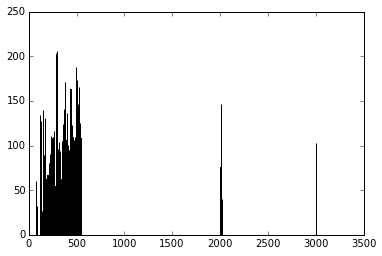

In [162]:
plt.bar(popular_stations, [station_counts[id] for id in popular_stations])